<a href="https://colab.research.google.com/github/sunRise9551/GPT_from_Scratch/blob/main/GPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [1]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2023-10-07 10:48:29--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.02s   

2023-10-07 10:48:29 (46.6 MB/s) - ‘input.txt’ saved [1115394/1115394]



The mathematical trick in self-attention

In [ ]:
# consider the following toy example:

torch.manual_seed(1337)
B, T, C = 4, 8, 2 # batch, time, channels
x = torch.randn(B, T, C)
x.shape

torch.Size([4, 8, 2])

In [ ]:
# We want x[b,t] = mean_{i<=t} x[b,i]
xbow = torch.zeros((B,T,C))
for b in range(B):
  for t in range(T):
    xprev = x[b, :t+1]

In [ ]:
B, T, C = 3, 4, 6
x = torch.randn(B, T, C)
xbow = torch.zeros((B,T,C))
for b in range(B):
  for t in range(T):
    xprev = x[b, :t+1]

print("X = \n", x)
print("xprev = \n", xprev)

X = 
 tensor([[[-0.8345,  0.5978, -0.0514, -0.0646, -0.4970,  0.4658],
         [-0.2573, -1.0673,  2.0089, -0.5370,  0.2228,  0.6971],
         [-1.4267,  0.9059,  0.1446,  0.2280,  2.4900, -1.2237],
         [ 1.0107,  0.5560, -1.5935, -1.2706,  0.6903, -0.1961]],

        [[ 0.3449, -0.3419,  0.4759, -0.7663, -0.4190, -0.4370],
         [-1.0012, -0.4094, -1.6669, -1.3651, -0.1655,  0.9623],
         [ 0.0315, -0.7419, -0.2978,  0.0172, -0.1772, -0.1334],
         [ 0.2940,  1.3850,  0.1209,  2.5418, -0.6405, -1.9740]],

        [[-0.3296,  0.0080,  0.9262, -1.8846,  0.1670,  0.4586],
         [-1.7662,  0.5860,  1.1346, -0.0824,  0.2893,  0.8358],
         [-0.2450,  0.2712,  0.0936, -0.8834, -0.3274,  0.0784],
         [-0.3808,  0.3775,  0.1119,  2.3143, -0.7989, -0.5643]]])
xprev = 
 tensor([[-0.3296,  0.0080,  0.9262, -1.8846,  0.1670,  0.4586],
        [-1.7662,  0.5860,  1.1346, -0.0824,  0.2893,  0.8358],
        [-0.2450,  0.2712,  0.0936, -0.8834, -0.3274,  0.0784],
      

If let's say we have an 'x' with (B,T,C) of (3,4,6)
- We have 3 batches
- Each batches have 4 sequences
- Each sequences have 6 channels

In [ ]:
B, T, C = 3, 4, 6
x = torch.randint(0, 10, (B, T, C))
x

tensor([[[3, 2, 3, 6, 1, 5],
         [4, 9, 5, 0, 4, 5],
         [4, 9, 5, 3, 5, 6],
         [1, 4, 4, 3, 6, 9]],

        [[8, 5, 1, 8, 4, 0],
         [9, 4, 7, 6, 1, 5],
         [0, 0, 4, 6, 3, 3],
         [3, 8, 6, 2, 5, 9]],

        [[0, 7, 7, 1, 2, 9],
         [8, 4, 3, 3, 1, 8],
         [5, 1, 5, 4, 7, 5],
         [1, 8, 4, 2, 0, 4]]])

Objective:
- We want our current input token are able to consider itself as well as previous tokens
- For example, taking 1st batch, 3rd sequence. (Index 1, 2)

In [ ]:
x[0,2]

tensor([4, 9, 5, 3, 5, 6])

- We want this current token of sequence, not only consider himself but all previous tokens.
- Which are:

In [ ]:
print(x[0,0])
print(x[0,1])
print(x[0,2]) # t, C

tensor([3, 2, 3, 6, 1, 5])
tensor([4, 9, 5, 0, 4, 5])
tensor([4, 9, 5, 3, 5, 6])


# Solution

## Simple Solution

- 1. Create `xprev` to store tracked/considered tokens
- 2. Create `xbow` zeros matrix to store calculated means
- 3. Calculate the mean of `xprev` on `t` dimension
- 4. Store calculated means to `xbow` according to current loop of `b` and `t`

Nested Loop
- looping the Batch, B
- looping the Timestamps, T

In [ ]:
B, T, C = 4, 8, 2
x = torch.rand(B, T, C)
xbow = torch.zeros(B,T,C)
for b in range(B):
  for t in range(T):
    xprev = x[b,:t+1] # (t,C)
    xbow[b,t] = torch.mean(xprev, 0)

print(x[0])
print("")
print(xbow[0])

tensor([[0.3970, 0.6915],
        [0.1728, 0.8323],
        [0.3802, 0.2879],
        [0.0983, 0.1698],
        [0.3482, 0.7270],
        [0.2465, 0.7241],
        [0.7451, 0.0122],
        [0.7501, 0.6190]])

tensor([[0.3970, 0.6915],
        [0.2849, 0.7619],
        [0.3167, 0.6039],
        [0.2621, 0.4954],
        [0.2793, 0.5417],
        [0.2738, 0.5721],
        [0.3412, 0.4921],
        [0.3923, 0.5080]])


## Optimizing ver1.0

- Using for loop is very unefficient.
- Matrix Multiplication can simplfy this.

Lower Triangular Matrix

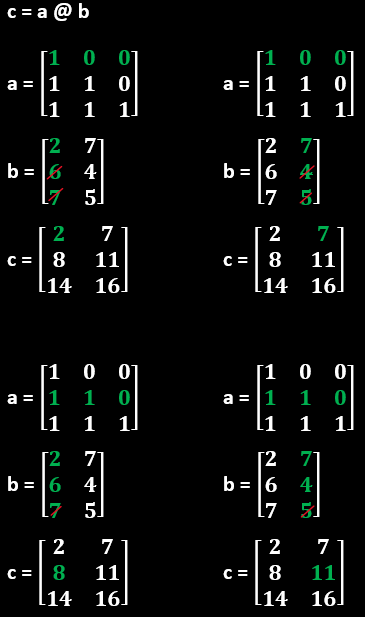

Triangular without calculating mean

In [ ]:
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3))
a = torch.ones(3, 3)
b = torch.randint(0, 10, (3, 2)).float()
c = a @ b
print("a = ")
print(a)
print("b = ")
print(b)
print("c = ")
print(c)

a = 
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
b = 
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
c = 
tensor([[14., 16.],
        [14., 16.],
        [14., 16.]])


- Calculate the mean by calculating the mean of matrix `a`
- Multiply with matrix `b`

In [ ]:
a = torch.tril(torch.ones(3, 3))
a = a / torch.sum(a, 1, keepdim=True)
a

tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])

In [ ]:
torch.manual_seed(42)
a = a / torch.sum(a, 1, keepdim=True)
b = torch.randint(0, 10, (3, 2)).float()
c = a @ b
print("a = ")
print(a)
print("b = ")
print(b)
print("c = ")
print(c)

a = 
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
b = 
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
c = 
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


## Optimizing Ver2.0

Vectorizing


- create a matrix that is `(T,T)`
- `T` is Timestamps
- `wei` is weights

In [ ]:
wei = torch.tril(torch.ones(T, T))
wei = wei / wei.sum(1, keepdim=True)
wei

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

- `wei` multiply with `x`
- `x` is `x = torch.rand(B, T, C)`

In [ ]:
xbow2 = wei @ x
# (T,T) @ (B,T,C) ---> (B,T,C)
# (B,T,T) @ (B,T,C) ---> (B,T,C)

Verify `xbow` and `xbow2`

In [ ]:
torch.allclose(xbow, xbow2)

True

In [ ]:
xbow[0], xbow2[0]

(tensor([[0.3970, 0.6915],
         [0.2849, 0.7619],
         [0.3167, 0.6039],
         [0.2621, 0.4954],
         [0.2793, 0.5417],
         [0.2738, 0.5721],
         [0.3412, 0.4921],
         [0.3923, 0.5080]]),
 tensor([[0.3970, 0.6915],
         [0.2849, 0.7619],
         [0.3167, 0.6039],
         [0.2621, 0.4954],
         [0.2793, 0.5417],
         [0.2738, 0.5721],
         [0.3412, 0.4921],
         [0.3923, 0.5080]]))

Wrap up

In [ ]:
wei = torch.tril(torch.ones(T, T))
wei = wei / wei.sum(1, keepdim=True)
xbow2 = wei @ x
torch.allclose(xbow, xbow2)

True

## Optimizing ver3.0

In [ ]:
tril = torch.tril(torch.ones(T,T))
tril

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])

In [ ]:
wei = torch.zeros(T, T)
wei

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

Masked everything on `wei`, according to element inside `tril` that is equal to 0, to -inf

In [ ]:
wei = wei.masked_fill(tril==0, float('-inf'))
wei

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
wei = F.softmax(wei, dim=-1)
wei

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

Wrap up

In [ ]:
tril = torch.tril(torch.ones(T,T))
wei = torch.zeros(T, T)
wei = wei.masked_fill(tril==0, float('-inf'))
wei = F.softmax(wei, dim=-1)

xbow3 = wei @ x
torch.allclose(xbow, xbow3)

True

- `weights` begin with 0
- Think of like an iteraction string, or affinity, so basically its telling us how much of each token from the past do we want to aggregate and average up

- For line `wei = wei.masked_fill(tril==0, float('-inf'))` is saying tokens from the past cannot communicate by setting them to `-inf`, we are saying that we will not aggregate anything from those tokens.

- It will then go through softmax, then aggregation.

- `wei = torch.zeros(T, T)` are currently just set by us to be 0, but these affinities between the tokens are not going to be just constant at zero, they are going to be data dependent.

- there tokens are going to start looking at each other, and some tokens will find other tokens more of less interesting, and depending on what their values are, they are going to find each other interesting to different amounts(affinities)

- Future cannot communicating with the past, we are going to clamp them and then when we normalize and sum, we will aggregate their values on how interesting they find each other

Long Story Short:
- We can do weighted aggregation on our past elements by using matrix multiplication of a lower triangular fashion
- Triangular part is telling us how much of each element fuses into this position.

That's all, That's the Self-Attention !

Optimizing ver4.0

Query Vector: What am I looking for

Key Vector: What do I contain

- Do a dot product between keys and queries
- For e.g, token 1 query dot product with all the keys of other tokens, and the dot product will become `weights`

- Think of x like a private information to this token
- For the purposes of the single head
-- here is what I'm interested in
-- here is what I have
-- if you find me interesting, here is what I will communicate to you
-- Its stored in v

- v is the thing that get aggregated for the purposes of this single head between the different nodes

In [ ]:
torch.manual_seed(1337)
B,T,C = 4,8,32
x = torch.randn(B,T,C)

head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)

k = key(x) # (B,T,16)
q = query(x) # (B,T,16)

wei = q @ k.transpose(-2,-1)
# (B,T,16) cannot multiply with (B,T,16)
# (B,T,16) @ (B,16,T) --> (B,T,T)
# Remeber that it is the query dot product with other keys


tril = torch.tril(torch.ones(T,T))
# wei = torch.zeros(T, T) # we will no longer need this
wei = wei.masked_fill(tril==0, float('-inf'))
wei = F.softmax(wei, dim=-1)

out = wei @ x
out.shape

torch.Size([4, 8, 32])

We need another Value

In [ ]:
torch.manual_seed(1337)
B,T,C = 4,8,32
x = torch.randn(B,T,C)

head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)

k = key(x) # (B,T,16)
q = query(x) # (B,T,16)

wei = q @ k.transpose(-2,-1)
# (B,T,16) cannot multiply with (B,T,16)
# (B,T,16) @ (B,16,T) --> (B,T,T)
# Remeber that it is the query dot product with other keys

tril = torch.tril(torch.ones(T,T))
# wei = torch.zeros(T, T) # we will no longer need this
wei = wei.masked_fill(tril==0, float('-inf'))
wei = F.softmax(wei, dim=-1)

# out = wei @ x
v = value(x)
out = wei @ v
out.shape

torch.Size([4, 8, 16])

Scaling is use just to control the variance at initialization

In [ ]:
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
wei = q @ k.transpose(-2,-1) #* head_size**-0.5

In [ ]:
print(k.var())
print(q.var())
print(wei.var())

tensor(1.0449)
tensor(1.0700)
tensor(17.4690)


In [ ]:
print(torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1))
print(torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5])*8, dim=-1))

tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])
tensor([0.0326, 0.0030, 0.1615, 0.0030, 0.8000])


In [ ]:
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
wei = q @ k.transpose(-2,-1) * head_size**-0.5

In [ ]:
print(k.var())
print(q.var())
print(wei.var())

tensor(0.9006)
tensor(1.0037)
tensor(0.9957)


In [ ]:
print(torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1))
print(torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5])*8, dim=-1))

tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])
tensor([0.0326, 0.0030, 0.1615, 0.0030, 0.8000])


# Attention is All You Need !

## One-Head-Attention

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 500
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 32

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# Created Head Module
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        # --------------------------------------------------------------------------
        # Initializing key, query, value, and torch.tril()
        # --------------------------------------------------------------------------
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        # --------------------------------------------------------------------------

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.sa_head = Head(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.sa_head(x) # apply one head of self-attention (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:] # <----------- Cropping out index, because we use positional embedding
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))
#open('more.txt', 'w').write(decode(m.generate(context, max_new_tokens=10000)[0].tolist()))

0.007553 M parameters
step 0: train loss 4.2010, val loss 4.2028
step 500: train loss 2.6260, val loss 2.6385
step 1000: train loss 2.4810, val loss 2.4983
step 1500: train loss 2.4376, val loss 2.4544
step 2000: train loss 2.4229, val loss 2.4267
step 2500: train loss 2.4079, val loss 2.4199
step 3000: train loss 2.4028, val loss 2.4122
step 3500: train loss 2.3885, val loss 2.4075
step 4000: train loss 2.3759, val loss 2.3991
step 4500: train loss 2.3686, val loss 2.4003

An ve boller ath thys AUTes st?

S: I tte thento bed whers, PORDund fr inorned omy heand:
I INIICome, bel gre?

Kor burikey?
A,
SILese, yore st borudd to on tesit the
Tu that sremer.

ILETOUEDI TAngu ade falivir, hint.

CAN Corto st fa bee thine yout wavefars foot t tere nd woimbes sses ldui, handy tshounof aneam,
A ost th yal wos, tras themaypur ald de hous:
ccof upren ingas hesittirilly tit th quiton ive ns im a;
MI akift wo thing! ow fol mun Is ave,
Rhe catel wroexpua, tohead wing fem,
Me
He?


## Multi-Head-Attention

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 500
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 32

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# Created Head Module
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        # --------------------------------------------------------------------------
        # Initializing key, query, value, and torch.tril()
        # --------------------------------------------------------------------------
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        # --------------------------------------------------------------------------

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
  """ multiple heads of self-attention in parallel"""

  def __init__(self, num_heads, head_size):
    super().__init__()
    self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])

  def forward(self, x):
    return torch.cat([h(x) for h in self.heads], dim=-1)
    # concatenating over channel dimension

class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.sa_head = MultiHeadAttention(4, n_embd//4) # i.e. 4 heads of 8-dimensional self-attention
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        # Taken Out in Multi-Head
        # --------------------------------------------------------------
        # x = self.sa_head(x) # apply one head of self-attention (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:] # <----------- Cropping out index, because we use positional embedding
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))
#open('more.txt', 'w').write(decode(m.generate(context, max_new_tokens=10000)[0].tolist()))

0.007553 M parameters
step 0: train loss 4.5454, val loss 4.5446
step 500: train loss 2.6895, val loss 2.7161
step 1000: train loss 2.5605, val loss 2.5816
step 1500: train loss 2.5184, val loss 2.5358
step 2000: train loss 2.5058, val loss 2.5135
step 2500: train loss 2.4971, val loss 2.5049
step 3000: train loss 2.4964, val loss 2.5031
step 3500: train loss 2.4807, val loss 2.4983
step 4000: train loss 2.4758, val loss 2.4913
step 4500: train loss 2.4703, val loss 2.4958
step 4999: train loss 2.4673, val loss 2.4886

Gsoulinoue
SRDforefitheeepirere meay genour HAsend tl ntothe cke ve winofitr,

Anrtin th brelpkint RDIOS:
Thinded, cer; BINENUTho an nyshowononoutererorareven y n shallle ceyort whe,
Was o r, rausele ARAnss ithofrveis po fie hourr whotodor sis, I yo tou acheshio ENREN IVS: huneslike,


AMacof Hera han d, hew, d, arl that, coul ver ss t my y y d,
CAMEule meloulare, my tour; ass, gof.
hid ue waimy wad vild m, d trardeay pifoffod whesis stile gotey ull thedecthatrsese ththa

## Feed Forward Module

We went way too fast when calculating the logits, resulting in the tokens looked at each other but didn't really have a lot of time to think on what they found from the other tokens.



In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 500
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 32

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# Created Head Module
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        # --------------------------------------------------------------------------
        # Initializing key, query, value, and torch.tril()
        # --------------------------------------------------------------------------
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        # --------------------------------------------------------------------------

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
  """ multiple heads of self-attention in parallel"""

  def __init__(self, num_heads, head_size):
    super().__init__()
    self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])

  def forward(self, x):
    return torch.cat([h(x) for h in self.heads], dim=-1)
    # concatenating over channel dimension
class FeedForward(nn.Module):
  """ a simple linear layer followed by a non-linearity """

  def __init__(self, n_embd):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(n_embd, n_embd),
        nn.ReLU(),
    )

  def forward(self, x):
    return self.net(x)

class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.sa_head = MultiHeadAttention(4, n_embd//4) # i.e. 4 heads of 8-dimensional self-attention
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        # Taken Out in Multi-Head
        # --------------------------------------------------------------
        # x = self.sa_head(x) # apply one head of self-attention (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:] # <----------- Cropping out index, because we use positional embedding
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))
#open('more.txt', 'w').write(decode(m.generate(context, max_new_tokens=10000)[0].tolist()))

0.007553 M parameters
step 0: train loss 4.5454, val loss 4.5446
step 500: train loss 2.6895, val loss 2.7161
step 1000: train loss 2.5605, val loss 2.5816
step 1500: train loss 2.5184, val loss 2.5358
step 2000: train loss 2.5058, val loss 2.5135
step 2500: train loss 2.4971, val loss 2.5049
step 3000: train loss 2.4964, val loss 2.5031
step 3500: train loss 2.4807, val loss 2.4983
step 4000: train loss 2.4758, val loss 2.4913
step 4500: train loss 2.4703, val loss 2.4958
step 4999: train loss 2.4673, val loss 2.4886

Gsoulinoue
SRDforefitheeepirere meay genour HAsend tl ntothe cke ve winofitr,

Anrtin th brelpkint RDIOS:
Thinded, cer; BINENUTho an nyshowononoutererorareven y n shallle ceyort whe,
Was o r, rausele ARAnss ithofrveis po fie hourr whotodor sis, I yo tou acheshio ENREN IVS: huneslike,


AMacof Hera han d, hew, d, arl that, coul ver ss t my y y d,
CAMEule meloulare, my tour; ass, gof.
hid ue waimy wad vild m, d trardeay pifoffod whesis stile gotey ull thedecthatrsese ththa

## Block Module

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 500
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200


torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# Created Head Module
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        # --------------------------------------------------------------------------
        # Initializing key, query, value, and torch.tril()
        # --------------------------------------------------------------------------
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        # --------------------------------------------------------------------------

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
  """ multiple heads of self-attention in parallel"""

  def __init__(self, num_heads, head_size):
    super().__init__()
    self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])

  def forward(self, x):
    return torch.cat([h(x) for h in self.heads], dim=-1)
    # concatenating over channel dimension
class FeedForward(nn.Module):
  """ a simple linear layer followed by a non-linearity """

  def __init__(self, n_embd):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(n_embd, n_embd),
        nn.ReLU(),
    )

  def forward(self, x):
    return self.net(x)

class Block(nn.Module):
  """ Transformer block: communication followed by computation"""

  def __init__(self, n_embd, n_head):
    # n_embd: embedding dimension
    # n_head: the number of heads we'd like
    super().__init__()
    head_size = n_embd // n_head
    self.sa = MultiHeadAttention(n_head, head_size)
    self.ffwd = FeedForward(n_embd)

  def forward(self, x):
    x = self.sa(x)
    x = self.ffwd(x)
    return x

class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(
            Block(n_embd, n_head=4),
            Block(n_embd, n_head=4),
            Block(n_embd, n_head=4),
        )
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        # x = self.sa_head(x) # apply one head of self-attention (B,T,C)
        # x = self.ffwd(x)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:] # <----------- Cropping out index, because we use positional embedding
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))
#open('more.txt', 'w').write(decode(m.generate(context, max_new_tokens=10000)[0].tolist()))

0.016865 M parameters
step 0: train loss 4.5229, val loss 4.5218
step 500: train loss 2.6974, val loss 2.7129
step 1000: train loss 2.5573, val loss 2.5759
step 1500: train loss 2.5149, val loss 2.5334
step 2000: train loss 2.5124, val loss 2.5169
step 2500: train loss 2.4960, val loss 2.5121
step 3000: train loss 2.4787, val loss 2.5025
step 3500: train loss 2.4754, val loss 2.4964
step 4000: train loss 2.4777, val loss 2.4922
step 4500: train loss 2.4655, val loss 2.4930
step 4999: train loss 2.4684, val loss 2.4943

Myoung. d par arot p ouck are
GO rsef II ingupa arieize u.
THithe XENI d.
Pe SI ougithisedenth th gren bout waith the, l.
A ilis.

ORIUKE:
Tha?
Wharst ay.
Fo---IAnd t tho witjur, anct w. turousar n t palletit, t nde 'sato'cge finompld be ma Vit r, f er be, marera iro veristen,
Asthenfoupwathiew,
An, ll healourd idshather dls ned d hil' t s. aren w idrTI thes murd;
CLe whayethe ngo ldrourn EAse far'ssee pindeane! t y rerrs cu Istheoug Rougr hive, t owivend cimy wes beshth

## Residual Connections

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 500
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200


torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# Created Head Module
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        # --------------------------------------------------------------------------
        # Initializing key, query, value, and torch.tril()
        # --------------------------------------------------------------------------
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        # --------------------------------------------------------------------------

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
  """ multiple heads of self-attention in parallel"""

  def __init__(self, num_heads, head_size):
    super().__init__()
    self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
    self.proj = nn.Linear(n_embd, n_embd) # <--------- Projection, simple linear layer

  def forward(self, x):
    out = torch.cat([h(x) for h in self.heads], dim=-1)
    out = self.proj(out) # <--------
    return out
    # concatenating over channel dimension

class FeedForward(nn.Module):
  """ a simple linear layer followed by a non-linearity """

  def __init__(self, n_embd):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(n_embd, n_embd),
        nn.ReLU(),
        nn.Linear(n_embd, n_embd),
    )

  def forward(self, x):
    return self.next(x)

class Block(nn.Module):
  """ Transformer block: communication followed by computation"""

  def __init__(self, n_embd, n_head):
    # n_embd: embedding dimension
    # n_head: the number of heads we'd like
    super().__init__()
    head_size = n_embd // n_head
    self.sa = MultiHeadAttention(n_head, head_size)
    self.ffwd = FeedForward(n_embd)

  def forward(self, x):
    # x = self.sa(x)
    # x = self.ffwd(x)
    x = x + self.sa(x)  # <-------- Residual
    x = x + self.ffwd(x)
    return x

class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(
            Block(n_embd, n_head=4),
            Block(n_embd, n_head=4),
            Block(n_embd, n_head=4),
        )
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        # x = self.sa_head(x) # apply one head of self-attention (B,T,C)
        # x = self.ffwd(x)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:] # <----------- Cropping out index, because we use positional embedding
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))
#open('more.txt', 'w').write(decode(m.generate(context, max_new_tokens=10000)[0].tolist()))

0.023201 M parameters
step 0: train loss 4.5071, val loss 4.5087
step 500: train loss 2.7043, val loss 2.7290
step 1000: train loss 2.5638, val loss 2.5813
step 1500: train loss 2.5165, val loss 2.5311
step 2000: train loss 2.5137, val loss 2.5175
step 2500: train loss 2.4981, val loss 2.5119
step 3000: train loss 2.4807, val loss 2.5007
step 3500: train loss 2.4851, val loss 2.4962
step 4000: train loss 2.4769, val loss 2.4927
step 4500: train loss 2.4656, val loss 2.4938
step 4999: train loss 2.4674, val loss 2.4960



Forounoraipy. wiueat anthis thy be e d tipinve seche s iim roun ouborsumy IEShiglie bin, d:
Has! st bu I'sout,
HUKOUSBRLones. ghe we, fouthlillof a banet mory tserd amulyorthave qurven ove se howerd bre r thit ith ve!
I thit hiong thath ceerd dy, Leayeat ot moict hey y tinor f shalongur, arnsp tuprm, thoy t holldubee weld; un mowin, wbat h's ct, prds oris t ge k, s m bl'dsest;
Tht shatopros

D re malor Et knd t bor ton t yend d h'dere.

Comed wakan;

LIZAne nat woven g

## Feed Forward Extra

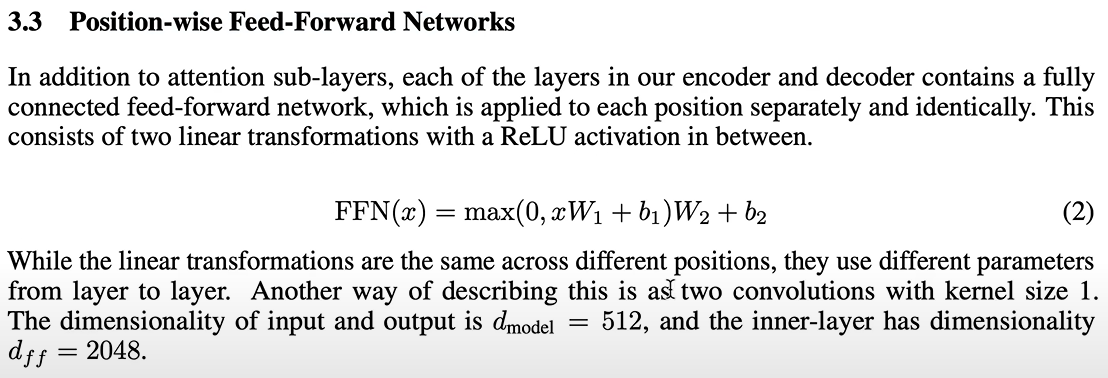

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?
max_iters = 30000
eval_interval = 500
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200


torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# Created Head Module
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        # --------------------------------------------------------------------------
        # Initializing key, query, value, and torch.tril()
        # --------------------------------------------------------------------------
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        # --------------------------------------------------------------------------

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
  """ multiple heads of self-attention in parallel"""

  def __init__(self, num_heads, head_size):
    super().__init__()
    self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
    self.proj = nn.Linear(n_embd, n_embd) # <--------- Projection, simple linear layer

  def forward(self, x):
    out = torch.cat([h(x) for h in self.heads], dim=-1)
    out = self.proj(out) # <--------
    return out
    # concatenating over channel dimension

class FeedForward(nn.Module):
  """ a simple linear layer followed by a non-linearity """

  def __init__(self, n_embd):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(n_embd, 4 * n_embd),
        nn.ReLU(),
        nn.Linear(4 * n_embd, n_embd),
    )

  def forward(self, x):
    return self.next(x)

class Block(nn.Module):
  """ Transformer block: communication followed by computation"""

  def __init__(self, n_embd, n_head):
    # n_embd: embedding dimension
    # n_head: the number of heads we'd like
    super().__init__()
    head_size = n_embd // n_head
    self.sa = MultiHeadAttention(n_head, head_size)
    self.ffwd = FeedForward(n_embd)

  def forward(self, x):
    # x = self.sa(x)
    # x = self.ffwd(x)
    x = x + self.sa(x)  # <-------- Residual
    x = x + self.ffwd(x)
    return x

class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(
            Block(n_embd, n_head=4),
            Block(n_embd, n_head=4),
            Block(n_embd, n_head=4),
        )
        self.lm_head = nn.Linear(n_embd, vocab_size)


    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        # x = self.sa_head(x) # apply one head of self-attention (B,T,C)
        # x = self.ffwd(x)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:] # <----------- Cropping out index, because we use positional embedding
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))
#open('more.txt', 'w').write(decode(m.generate(context, max_new_tokens=10000)[0].tolist()))

0.041921 M parameters
step 0: train loss 4.4835, val loss 4.4927
step 500: train loss 2.6955, val loss 2.7145
step 1000: train loss 2.5586, val loss 2.5673
step 1500: train loss 2.5179, val loss 2.5366
step 2000: train loss 2.4984, val loss 2.5124
step 2500: train loss 2.4914, val loss 2.4986
step 3000: train loss 2.4798, val loss 2.4904
step 3500: train loss 2.4810, val loss 2.4829
step 4000: train loss 2.4784, val loss 2.4904
step 4500: train loss 2.4708, val loss 2.4942
step 5000: train loss 2.4686, val loss 2.4941
step 5500: train loss 2.4657, val loss 2.4855
step 6000: train loss 2.4644, val loss 2.4833
step 6500: train loss 2.4708, val loss 2.4923
step 7000: train loss 2.4606, val loss 2.4930
step 7500: train loss 2.4656, val loss 2.4898
step 8000: train loss 2.4673, val loss 2.4884
step 8500: train loss 2.4671, val loss 2.4763
step 9000: train loss 2.4623, val loss 2.4788
step 9500: train loss 2.4660, val loss 2.4812
step 10000: train loss 2.4603, val loss 2.4889
step 10500: tra

## Layer Norm

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?
max_iters = 30000
eval_interval = 500
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 4

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# Created Head Module
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        # --------------------------------------------------------------------------
        # Initializing key, query, value, and torch.tril()
        # --------------------------------------------------------------------------
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        # --------------------------------------------------------------------------

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
  """ multiple heads of self-attention in parallel"""

  def __init__(self, num_heads, head_size):
    super().__init__()
    self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
    self.proj = nn.Linear(n_embd, n_embd) # <--------- Projection, simple linear layer

  def forward(self, x):
    out = torch.cat([h(x) for h in self.heads], dim=-1)
    out = self.proj(out) # <--------
    return out
    # concatenating over channel dimension

class FeedForward(nn.Module):
  """ a simple linear layer followed by a non-linearity """

  def __init__(self, n_embd):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(n_embd, 4 * n_embd),
        nn.ReLU(),
        nn.Linear(4 * n_embd, n_embd),
    )

  def forward(self, x):
    return self.next(x)

class Block(nn.Module):
  """ Transformer block: communication followed by computation"""

  def __init__(self, n_embd, n_head):
    # n_embd: embedding dimension
    # n_head: the number of heads we'd like
    super().__init__()
    head_size = n_embd // n_head
    self.sa = MultiHeadAttention(n_head, head_size)
    self.ffwd = FeedForward(n_embd)
    self.ln1 = nn.LayerNorm(n_embd) # <-------- Layer Norm
    self.ln2 = nn.LayerNorm(n_embd)

  def forward(self, x):
    # x = self.sa(x)
    # x = self.ffwd(x)
    x = x + self.sa((self.ln1(x))) # <------- Apply Layer Norm
    x = x + self.ffwd((self.ln2(x)))
    return x

class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(
            Block(n_embd, n_head=4),
            Block(n_embd, n_head=4),
            Block(n_embd, n_head=4),
            nn.LayerNorm(n_embd), # <----- Layer Norm
        )
        self.lm_head = nn.Linear(n_embd, vocab_size)


    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        # x = self.sa_head(x) # apply one head of self-attention (B,T,C)
        # x = self.ffwd(x)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:] # <----------- Cropping out index, because we use positional embedding
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))
#open('more.txt', 'w').write(decode(m.generate(context, max_new_tokens=10000)[0].tolist()))

# X

In [9]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from tqdm import tqdm

# hyperparameters
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 256 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.2
# ------------

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = GPTLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

model_save_path = './my_model.pth'

for iter in tqdm(range(max_iters), desc="Training Progress"):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

        torch.save(model.state_dict(), model_save_path)
        print(f"Model saved at {model_save_path}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

torch.save(model.state_dict(), model_save_path)
print(f"Final model saved at {model_save_path}")

10.788929 M parameters


Training Progress:   0%|          | 0/5000 [00:00<?, ?it/s]

step 0: train loss 4.2221, val loss 4.2306
Model saved at ./my_model.pth


Training Progress:  10%|█         | 500/5000 [05:25<37:49,  1.98it/s]

step 500: train loss 1.7599, val loss 1.9162
Model saved at ./my_model.pth


Training Progress:  20%|██        | 1000/5000 [10:50<33:42,  1.98it/s]

step 1000: train loss 1.3933, val loss 1.6023
Model saved at ./my_model.pth


Training Progress:  30%|███       | 1500/5000 [16:14<29:18,  1.99it/s]

step 1500: train loss 1.2685, val loss 1.5291
Model saved at ./my_model.pth


Training Progress:  40%|████      | 2000/5000 [21:36<25:04,  1.99it/s]

step 2000: train loss 1.1868, val loss 1.4955
Model saved at ./my_model.pth


Training Progress:  50%|█████     | 2500/5000 [26:59<21:01,  1.98it/s]

step 2500: train loss 1.1219, val loss 1.4860
Model saved at ./my_model.pth


Training Progress:  60%|██████    | 3000/5000 [32:22<16:39,  2.00it/s]

step 3000: train loss 1.0737, val loss 1.4861
Model saved at ./my_model.pth


Training Progress:  70%|███████   | 3500/5000 [37:44<12:32,  1.99it/s]

step 3500: train loss 1.0215, val loss 1.5081
Model saved at ./my_model.pth


Training Progress:  80%|████████  | 4000/5000 [43:06<08:19,  2.00it/s]

step 4000: train loss 0.9648, val loss 1.5082
Model saved at ./my_model.pth


Training Progress:  90%|█████████ | 4500/5000 [48:27<04:08,  2.01it/s]

step 4500: train loss 0.9082, val loss 1.5378
Model saved at ./my_model.pth


Training Progress: 100%|█████████▉| 4999/5000 [53:48<00:00,  2.00it/s]

step 4999: train loss 0.8546, val loss 1.5600
Model saved at ./my_model.pth


Training Progress: 100%|██████████| 5000/5000 [55:01<00:00,  1.51it/s]


Final model saved at ./my_model.pth

But with prison chariteds entremity.

SLY:
Why stay you shall hold have fled a time.

STaPHEN SCAPULET:
Then gave me no more than than it movested
by my sweet grace than yet ever saw me
My sweet legs in to tears me now.
That comfortal to his edgracious swaing:
And office my own, it is a mystery toad,
How becaury I was enjoy or your love?
Was ever I kingdomed by unto my love
Imploy'd in me again?

BRUTUS:
O well'd you!

All:
About undon this time, to dissay them yoke
Were his rebels companion and


In [11]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=5000)[0].tolist()))
open('more.txt', 'w').write(decode(m.generate(context, max_new_tokens=10000)[0].tolist()))


My purge devo, you'll make a better most very idle.

CLARENCE:

MONTAGUE:
Good jod-day. Bending with this deep day,
And am a wife and kindled eye.

KING EDWARD IV:
Bring forth, yet orders, you entire, beat,
Against us to Cypan here forth Duke of York,
And, Richard, I did still to London, and their ears.
I was his sons, leave it to his mind;
The is and aughter of the Bitter Lancas.

DUKE OF YORK:
My hair of Lancas: the daughter of a king.

DUCHESS OF YORK:
Ever doth be witness with my pride and thine.

QUEEN ELIZABTH:
Thou art no near, thy company might one a drawncical;
That Tybalt shall slain dead Polixenes,
Gives, until no received that touch of this daughter
For she that can at ride? at that fhat is made?

DUKE OF YORK:
Here dead, if you are; and never breath
To sedice in the scarde; incenside, where you have
To seee your arms and into you to rather.

DUKE OF YORK:
Then, Bianca, if Warwick many this depart, debt.

DUKE OF YORK:
I cannot great
Should not, unless thing abow end to sl

10001